## Importing libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from tensorflow.train import Example, Features, Feature, BytesList, Int64List
from contextlib import ExitStack
import matplotlib.pyplot as plt
from datetime import datetime
import os

## Loading dataset

In [2]:
(x_train_full, y_train_full), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
x_valid, x_train = x_train_full[:5000], x_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [3]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [4]:
# Creating a dataset from the loaded data arrays
train_set = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(len(x_train))
valid_set = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
test_set = tf.data.Dataset.from_tensor_slices((x_test, y_test))

In [5]:
train_set

<ShuffleDataset shapes: ((28, 28), ()), types: (tf.uint8, tf.uint8)>

In [6]:
valid_set

<TensorSliceDataset shapes: ((28, 28), ()), types: (tf.uint8, tf.uint8)>

In [7]:
# Func to create Example from the above tensors
def create_example(image, label):
    image_data = tf.io.serialize_tensor(image) # Serializing the tensors in the dataset
    return Example(features = Features(feature = {'image' : Feature(bytes_list = BytesList(value = [image_data.numpy()])), # Creating the Example
                                                  'label' : Feature(int64_list = Int64List(value = [label]))}))

In [8]:
for image, label in valid_set.take(1):
    print(create_example(image, label))

features {
  feature {
    key: "image"
    value {
      bytes_list {
        value: "\010\004\022\010\022\002\010\034\022\002\010\034\"\220\006\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\001\000\000\rI\000\000\001\004\000\000\000\000\001\001\000\000\000\000\000\000\000\000\000\000\000\000\000\003\000$\210\177>6\000\000\000\001\003\004\000\000\003\000\000\000\000\000\000\000\000\000\000\000\000\006\000f\314\260\206\220{\027\000\000\000\000\014\n\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\233\354\317\262k\234\241m@\027M\202H\017\000\000\000\000\000\000\000\000\000\000\000\001\000E\317\337\332\330\330\243\177yz\222\215X\254B\000\000\00

In [9]:
# Function for writing the examples into multiple TFRecord files
def write_tfrecords(name, dataset, n_shards = 10):
    paths = ['{}.tfrecord-{:05d}-of-{:05d}'.format(name, index, n_shards) for index in range(n_shards)] # Creating the paths
    with ExitStack() as stack: # Exitstack used to make sure all writers are properly closed and whether or not an I/O error occurs while writing.
        writers = [stack.enter_context(tf.io.TFRecordWriter(path)) for path in paths] # Statement to open the files which will be closed at the end of with statement.
        for index, (image, label) in dataset.enumerate(): # Enumerating the dataset to get the index, image and label
            shard = index % n_shards # Deciding on which file to write to based on the remainder of the division of index by n_shards.
            example = create_example(image, label) # Examples are created
            writers[shard].write(example.SerializeToString()) # Examples are serialized and written to respective files.
    return paths

In [10]:
train_filepaths = write_tfrecords('Fashion_MNIST_train', train_set)
valid_filepaths = write_tfrecords('Fashion_MNIST_valid', valid_set)
test_filepaths = write_tfrecords('Fashion_MNIST_test', test_set)

In [11]:
# Function for extracting the data from the TFRecord file
def preprocess(tfrecord):
    # The feature description is defined for extraction from the file
    feature_desc = {'image' : tf.io.FixedLenFeature([], tf.string, default_value = ''), 'label' : tf.io.FixedLenFeature([], tf.int64, default_value = -1)}
    example = tf.io.parse_single_example(tfrecord, feature_desc) # TFRecord files are parsed
    image = tf.io.parse_tensor(example['image'], out_type = tf.uint8) # The image part from the example is parsed out to a tensor
    image = tf.reshape(image, shape = [28, 28]) # The tensor is reshaped to the required size
    return image, example['label']

In [12]:
# Function to read the TFRecord files saved above and parse them
def mnist_dataset(filepaths, n_read_threads = 5, shuffle_buffer_size = None, n_parse_threads = 5, batch_size = 32, cache = True):
    dataset = tf.data.TFRecordDataset(filepaths, num_parallel_reads = n_read_threads) # Reading the TFRecord files from the filepaths provided.
    if cache:
        dataset = dataset.cache() # Caching the dataset if required
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size) # Shuffling the dataset if required
    dataset = dataset.map(preprocess, num_parallel_calls = n_parse_threads) # Calling the preprocess func def above to parse the dataset formed
    dataset = dataset.batch(batch_size) # Seperating the dataset into batches
    return dataset.prefetch(1) # Returning the dataset batch-wise using prefetching.

In [13]:
train_set = mnist_dataset(train_filepaths, shuffle_buffer_size = 60000)
valid_set = mnist_dataset(valid_filepaths)
test_set = mnist_dataset(test_filepaths)

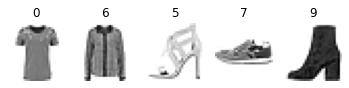

In [14]:
for x, y in train_set.take(1): # X and y consists of 32 images and labels(i.e. one batch) respectively.
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(x[i].numpy(), cmap = 'binary' )
        plt.axis('off')
        plt.title(str(y[i].numpy()))

In [15]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [16]:
# Defining custom layer for Standardization of input
class Standardization(keras.layers.Layer):
    def adapt(self, data_sample): # Method for caluculating the mean and SD from a sample of the data.
        self.means_ = np.mean(data_sample, axis = 0, keepdims = True)
        self.stds_ = np.std(data_sample, axis = 0, keepdims = True)
    def call(self, inputs):
        return (inputs - self.means_) / (self.stds_ + keras.backend.epsilon())

In [17]:
standardization = Standardization(input_shape = [28, 28])

- We have to call the adapt method of the Standardization layer before using it in the model to calculate the mean and Sd to be used.

In [18]:
sample_image_batches = train_set.take(100).map(lambda image, label : image)

In [19]:
sample_image_batches

<MapDataset shapes: (None, 28, 28), types: tf.uint8>

In [20]:
sample_images = np.concatenate(list(sample_image_batches.as_numpy_iterator()), axis = 0).astype(np.float32)

In [21]:
standardization.adapt(sample_images)

In [22]:
model = keras.models.Sequential()
model.add(standardization)
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100, activation = 'relu'))
model.add(keras.layers.Dense(10, activation = 'softmax'))

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
standardization (Standardiza (None, 28, 28)            0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.compile(loss = keras.losses.sparse_categorical_crossentropy, optimizer = 'nadam', metrics = ['accuracy'])

In [25]:
datetime.now().strftime('%Y_%m_%d__%H_%M_%S')

'2020_10_06__19_43_31'

In [26]:
logs = os.path.join(os.curdir, 'MNIST_logs', 'run_' + datetime.now().strftime('%Y_%m_%d__%H_%M_%S'))

In [27]:
tensorboard_cb = keras.callbacks.TensorBoard(log_dir = logs, histogram_freq = 1, profile_batch = (10))

In [28]:
model.fit(train_set, epochs = 5, validation_data = valid_set, callbacks = [tensorboard_cb])

Epoch 1/5
      1/Unknown - 0s 254us/step - loss: 3.2469 - accuracy: 0.0312WARNING:tensorflow:From /home/gokul/.local/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1719/1719 [==============================] - 3s 2ms/step - loss: 570.1453 - accuracy: 0.8415 - val_loss: 149.1324 - val_accuracy: 0.8670
Epoch 2/5
1719/1719 [==============================] - 3s 2ms/step - loss: 639.2181 - accuracy: 0.8785 - val_loss: 282.7335 - val_accuracy: 0.8730
Epoch 3/5
1719/1719 [==============================] - 3s 2ms/step - loss: 98.2002 - accuracy: 0.8905 - val_loss: 0.3451 - val_accuracy: 0.8790
Epoch 4/5
1719/1719 [==============================] - 3s 2ms/step - loss: 437.1322 - accuracy: 0.9015 - val_loss: 152.0150 - val_accuracy: 0.8792
Epoch 5/5
1719/1719 [==============================] - 3s 2ms/st